
# Welcome to the IndabaX 2024 Guided Hackathon with Isazi!


## 1. Introduction
*********************************

#### 1.1. Problem Domain

In the fast-paced retail sector, understanding and predicting sales volumes is crucial for effective inventory management, pricing strategy, and promotional planning. Accurately forecasting sales not only optimizes operational efficiencies but also enhances customer satisfaction by ensuring product availability and competitive pricing.

#### 1.2 Challenge Description

Participants are tasked with developing a predictive model that forecasts the future sales volumes of various products based on historical sales data. The dataset provided includes daily sales figures, promotional activities, and pricing information. The primary objective is to predict the volume of product sales for upcoming dates, which is critical for managing supply chain and marketing strategies.

#### 1.3. Objectives
- **Feature Engineering**: Identify and harness the influence of promotional activities and pricing strategies on sales volumes.
- **Model Development**: Build robust time series forecasting models that can accurately predict sales volumes.

#### 1.4. Evaluation Criteria

The evaluation of forecasting models in this challenge uses two primary metrics: Overall Forecast Accuracy and Relative Bias. These metrics are calculated as follows:

1. **Total Sales Volume**: Sum the actual sales volumes across all time series to obtain the total actual volume.
2. **Total Predicted Volume**: Sum the predicted sales volumes across all time series.
3. **Total Error**: Compute the absolute error between predicted and actual sales volumes for each prediction, and then sum these errors across all time series.
4. **Relative Error**: Divide the total error by the total actual volume to obtain the relative error.
5. **Forecast Accuracy**: Calculate forecast accuracy as `1 - Relative Error`.
6. **Relative Bias**: Compute the relative bias by subtracting the total actual volume from the total predicted volume and dividing the result by the total actual volume. This metric indicates the tendency of the models to overestimate or underestimate the sales volumes.

These metrics ensure a comprehensive evaluation of model performance:
- **Forecast Accuracy** emphasizes the precision of individual predictions and is weighted towards time series with higher sales volumes, which are more significant for overall business performance.
- **Relative Bias** measures the overall tendency of the predictions to be higher or lower than actual values, providing insight into the systemic accuracy of the models.

Models will be judged not only on how accurately they predict sales volumes but also on how well they maintain balance, avoiding systematic overestimation or underestimation of sales.

#### 1.5. Usefulness of the Challenge

The solutions developed during this hackathon will help businesses:
- **Enhance Decision Making**: Improve inventory and pricing decisions by predicting demand more accurately.
- **Optimize Promotional Strategies**: Understand the impact of various promotional tactics on sales and adjust these strategies to maximize profitability.
- **Reduce Waste and Shortages**: Better demand forecasts lead to more efficient supply chain management, reducing both excess stock and product shortages.

#### 1.6. Outcome

This challenge offers participants the opportunity to apply machine learning techniques to a real-world problem, enhancing their skills in data manipulation, model building, and evaluation. The top-performing models could potentially be implemented in real retail environments, demonstrating the practical value of predictive analytics in business contexts.

#### 1.7. Support Channels
* SwapCard Hackathon Discussion Forum

#### 1.8. Mentor and Support
* Kilian Massa

#### 1.9. Submission Process
The evaluation of forecasting models in this competition focuses on two key metrics:
Overall Forecast Accuracy and Relative Bias.

### Let's get started!

## 0. Setup
****************************************************************

#### 0.1 Mounting Google Drive

Running this Notebook on Google Colab?

* If yes, run the next cell.
* If No, Skip to 0.3: Update working directory.

#### 0.2. Update Working Directory

In [79]:
import os
path = os.getcwd()
path

'/home/ryan/Workspace/personal/isazi-hackathon-indabaX'

#### 0.3. Install Necessary Packages

#### 0.4 Import Packages

In [80]:
import json  # Standard library for working with JSON data

import pandas as pd  # Powerful data manipulation and analysis library
import numpy as np  # Library for numerical computations
np.bool = np.bool_
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations
import seaborn as sns  # Data visualization library based on matplotlib, provides a high-level interface for drawing attractive and informative statistical graphics

from sklearn.model_selection import train_test_split  # Utility for splitting the dataset into training and testing sets
from sklearn.preprocessing import StandardScaler  # Utility for standardizing features by removing the mean and scaling to unit variance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Metrics for evaluating the performance of a regression model

from gluonts.dataset.pandas import PandasDataset  # GluonTS utility for creating datasets from pandas dataframes
from gluonts.evaluation.backtest import make_evaluation_predictions  # Utility for generating evaluation predictions from a trained model
from gluonts.evaluation import Evaluator  # Utility for evaluating the performance of time series forecasting models

from gluonts.mx import SimpleFeedForwardEstimator, Trainer # GluonTS classes for creating and training a simple feed-forward neural network model


#### 0.5 Define Constants

In [81]:
# Dataset paths and column definitions
time_series_id_col = 'product_code'
date_col = 'sales_date'
target_col = 'volume'
freq = "1D"
prediction_length = 28
data_path = os.path.join(path, "data/isazi_ts_dataset.csv")


## 2. Loading Data
*********************************

In [82]:
# Load the dataset
df = pd.read_csv(data_path)
# Rename the incorrect column
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Convert the sales date to a datetime type
df['sales_date'] = pd.to_datetime(df['sales_date'], format='%Y-%m-%d')

# Display the df
df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,NaN,1
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,NaN,2
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,NaN,3
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5
...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,NaN,147
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,NaN,85
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,NaN,98


## 3. Data Preprocessing
********************************
In this section, we'll preprocess the data to make it suitable for modeling. This includes handling missing values, encoding categorical variables, and scaling numerical features.

The dataset consists of the following columns:
- `sales_date`: Date of the sales record.
- `volume`: Number of units sold.
- `rel_promo_price`: Relative promotional price.
- `is_promo`: Indicator if the item was on promotion.
- `is_single_price_promo`: Indicator if there was a single price promotion.
- `is_multibuy_promo`: Indicator if there was a multibuy promotion.
- `rsp`: Retail selling price.
- `planned_promo_vol`: Planned promotional volume.
- `product_code`: Unique product identifier.
"""

`NB`: all the promo covariates (is_promo, planned_promo_vol, rel_promo_price, is_multibuy_promo) are reported by the supplier, and the volume we are predicting is the volume sold by the retailer, i.e. the supplier is essentially giving us an estimate of the retailer's promotions.

## 4. Exploratory Data Analysis (EDA)
********************************

Before building the model, it's essential to understand the data through exploratory data analysis (EDA).


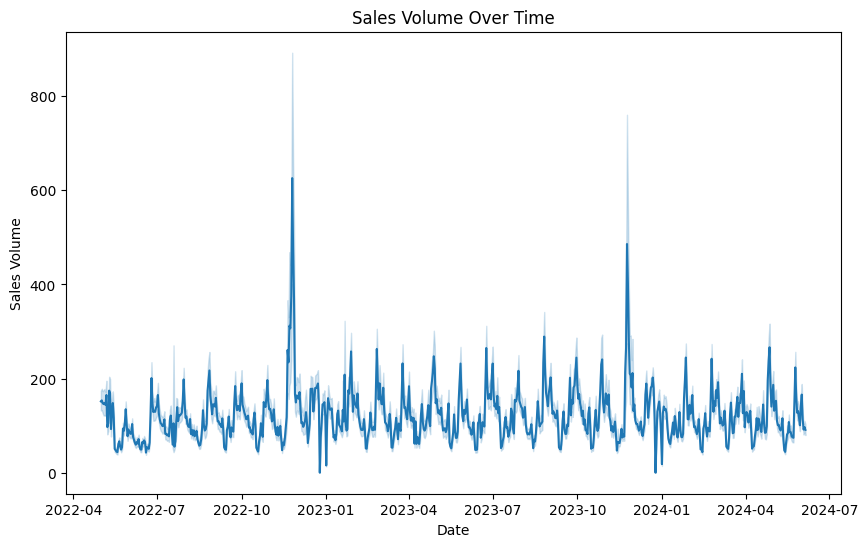

In [83]:
# Plot total sales volume (aggregate over product) over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='sales_date', y='volume', data=df)
plt.title('Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.show()

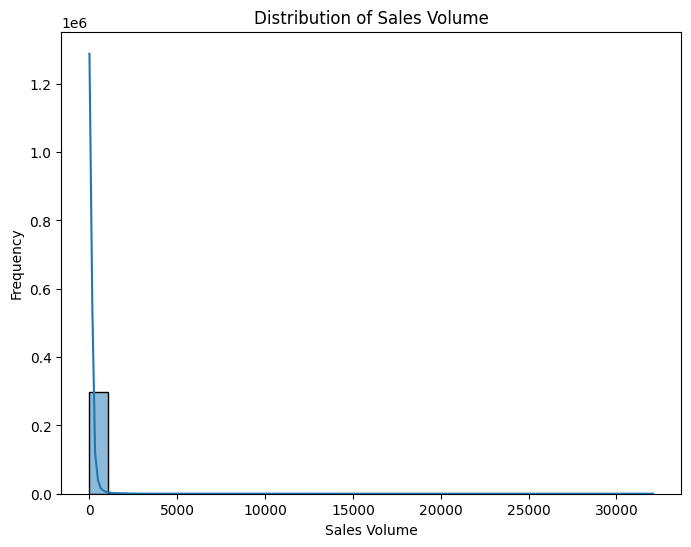

/home/ryan/Workspace/personal/isazi-hackathon-indabaX/hackathon-venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


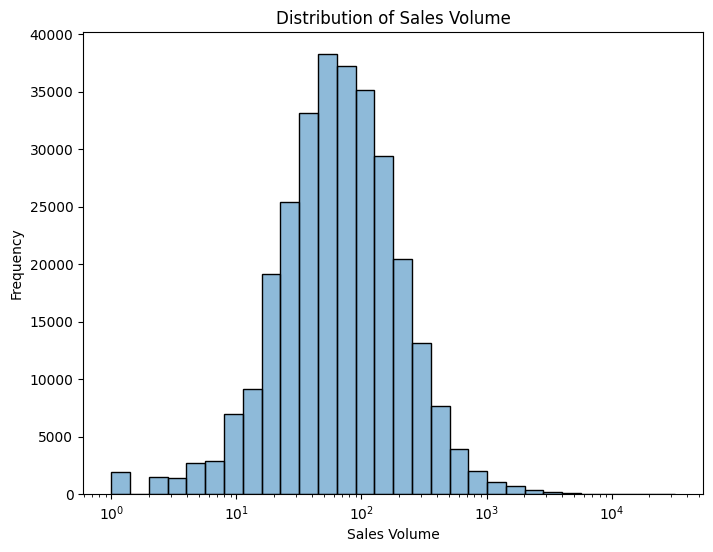

In [84]:
# Distribution of sales volume
plt.figure(figsize=(8, 6))
sns.histplot(df['volume'], bins=30, kde=True)
plt.title('Distribution of Sales Volume')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.show()

# Distribution of log of the sales volume
plt.figure(figsize=(8, 6))
sns.histplot(df['volume'], bins=30, kde=True, log_scale = True)
plt.title('Distribution of Sales Volume')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.show()

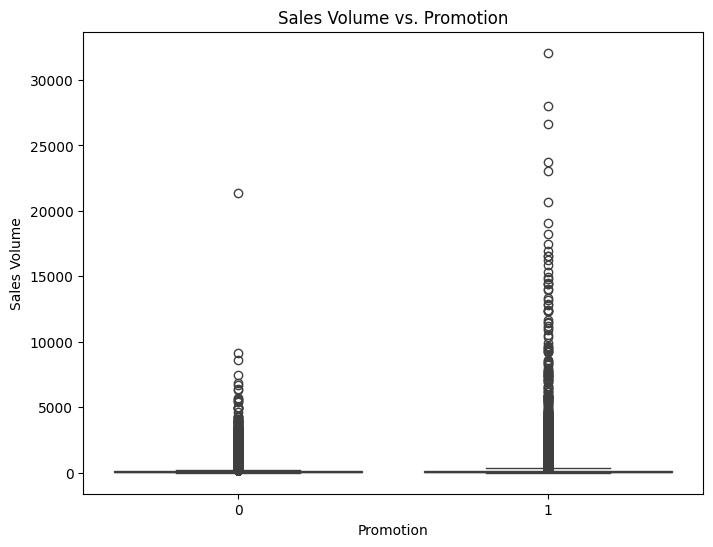

Average sales volume by promotion:
is_promo
0     96.271113
1    143.403851
Name: volume, dtype: float64


In [85]:
# Sales volume vs. promotion
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_promo', y='volume', data=df)
plt.title('Sales Volume vs. Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales Volume')
plt.show()

# Average sales volume by promotion
print("Average sales volume by promotion:")
print(df.groupby('is_promo')['volume'].mean())


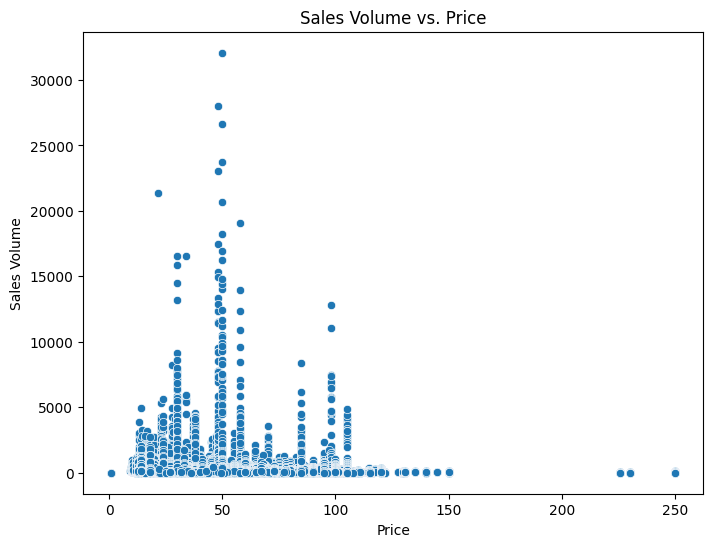

Correlation between price and sales volume:
             rsp    volume
rsp     1.000000 -0.120048
volume -0.120048  1.000000


In [86]:
# Sales volume vs. price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rsp', y='volume', data=df)
plt.title('Sales Volume vs. Price')
plt.xlabel('Price')
plt.ylabel('Sales Volume')
plt.show()

# Correlation between price and sales volume
print("Correlation between price and sales volume:")
print(df[['rsp', 'volume']].corr())


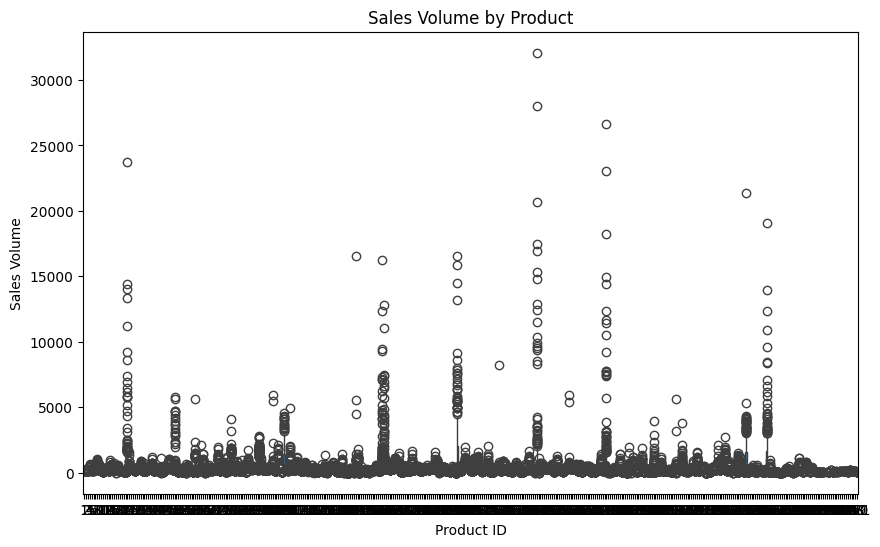

Average sales volume by product:
product_code
1       76.757497
2       64.371578
3       56.235984
4      171.852673
5       66.667536
          ...    
407     82.383764
408     58.664207
409     44.660517
410     59.051661
411     20.435424
Name: volume, Length: 411, dtype: float64


In [87]:
# Sales volume by product
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_code', y='volume', data=df)
plt.title('Sales Volume by Product')
plt.xlabel('Product ID')
plt.ylabel('Sales Volume')
plt.show()

# Average sales volume by product
print("Average sales volume by product:")
print(df.groupby('product_code')['volume'].mean())


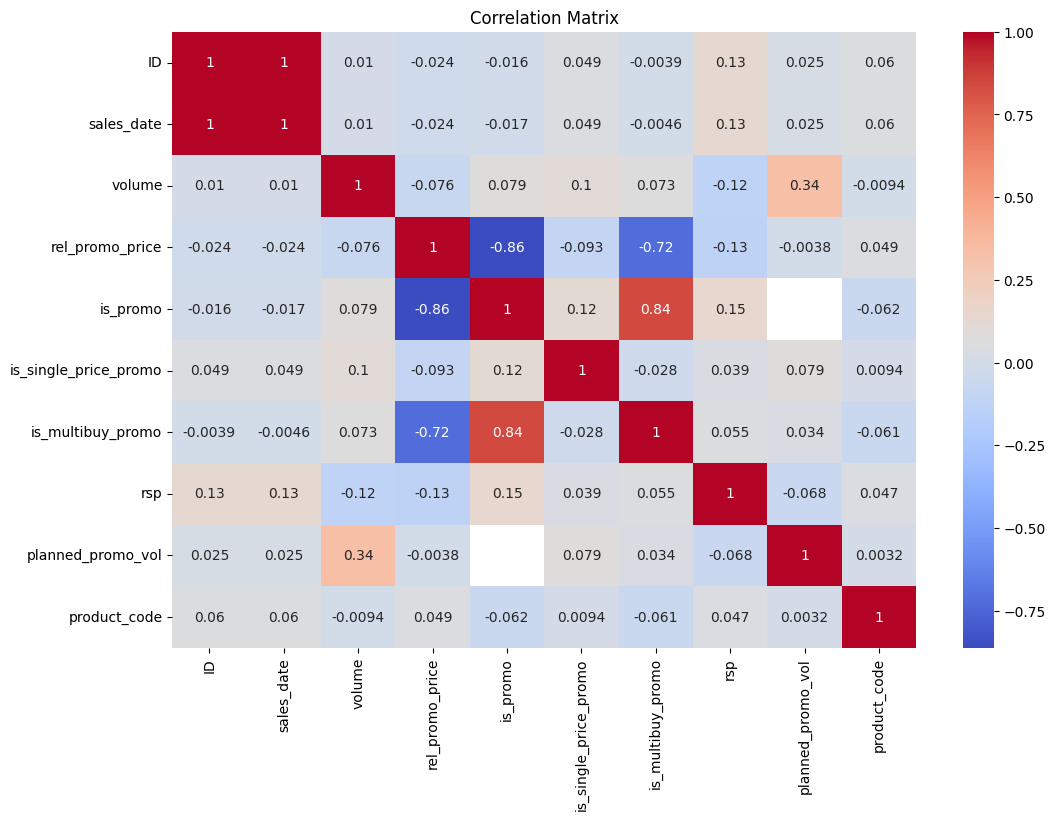

In [88]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 5. Feature Engineering
********************************
Feature engineering involves creating new features or modifying existing ones to improve the model's performance.


In [89]:
# Extract additional time features
df['year'] = df['sales_date'].dt.year
df['month'] = df['sales_date'].dt.month
df['day'] = df['sales_date'].dt.day
df['dayofweek'] = df['sales_date'].dt.dayofweek

# Create date diff string
sales_starting_date = df['sales_date'].iloc[0]
df['date_diff'] = (df['sales_date'] - sales_starting_date) / np.timedelta64(1, 'D') # Basically a column that tells you what day you are at relative to the start

# Fill nans in planned_promo_vol
df.fillna(0, inplace = True) # Replace any NaNs with 0

df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,date_diff
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1,2022,5,1,6,0.0
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2,2022,5,1,6,0.0
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3,2022,5,1,6,0.0
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4,2022,5,1,6,0.0
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5,2022,5,1,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156,2024,6,5,2,766.0
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,0.0000,147,2024,6,5,2,766.0
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,0.0000,85,2024,6,5,2,766.0
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,0.0000,98,2024,6,5,2,766.0


## 6. Data Preparation
********************************

#### 6.1 Split into Train and Test Set

In [90]:
def split_time_series(df, prediction_length):
    """
    Function to split off a df of time series into time series, where the second time series
    includes the last `prediction_length` time steps.
    """
    # Create an empty dataframe for train and validation sets
    train_df = pd.DataFrame()
    validation_df = pd.DataFrame()

    # Group by the time series identifier
    grouped = df.groupby(time_series_id_col)

    # Iterate over each group (i.e., each individual time series)
    for item_id, group in grouped:
        # Sort the group by date if it's not already sorted
        group = group.sort_index()

        # Define the split point
        split_point = len(group) - prediction_length

        # Split the data into training and validation sets
        train_group = group.iloc[:split_point]
        validation_group = group

        # Append to the respective dataframes
        train_df = pd.concat([train_df, train_group])
        validation_df = pd.concat([validation_df, validation_group])

    return train_df, validation_df

train_df, test_df = split_time_series(df, prediction_length)

In [91]:
train_df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,date_diff
0,0,2022-05-01,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,1,6,0.0
599,599,2022-05-02,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,2,0,1.0
843,843,2022-05-03,60.0,1.0,0,0,0,32.9500,0.0,1,2022,5,3,1,2.0
1409,1409,2022-05-04,61.0,1.0,0,0,0,32.9656,0.0,1,2022,5,4,2,3.0
1485,1485,2022-05-05,49.0,1.0,0,0,0,32.9656,0.0,1,2022,5,5,3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287531,287531,2024-05-04,15.0,1.0,0,0,0,16.0679,0.0,411,2024,5,4,5,734.0
287796,287796,2024-05-05,10.0,1.0,0,0,0,16.0679,0.0,411,2024,5,5,6,735.0
288185,288185,2024-05-06,12.0,1.0,0,0,0,16.0679,0.0,411,2024,5,6,0,736.0
288598,288598,2024-05-07,14.0,1.0,0,0,0,16.0679,0.0,411,2024,5,7,1,737.0


In [92]:
test_df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,date_diff
0,0,2022-05-01,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,1,6,0.0
599,599,2022-05-02,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,2,0,1.0
843,843,2022-05-03,60.0,1.0,0,0,0,32.9500,0.0,1,2022,5,3,1,2.0
1409,1409,2022-05-04,61.0,1.0,0,0,0,32.9656,0.0,1,2022,5,4,2,3.0
1485,1485,2022-05-05,49.0,1.0,0,0,0,32.9656,0.0,1,2022,5,5,3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299032,299032,2024-06-01,15.0,1.0,0,0,0,16.0679,0.0,411,2024,6,1,5,762.0
299331,299331,2024-06-02,7.0,1.0,0,0,0,16.0679,0.0,411,2024,6,2,6,763.0
299673,299673,2024-06-03,13.0,1.0,0,0,0,16.0679,0.0,411,2024,6,3,0,764.0
300005,300005,2024-06-04,6.0,1.0,0,0,0,16.0679,0.0,411,2024,6,4,1,765.0


#### 6.2. Scaling and Normalization

In [93]:
# Encode categorical variables (if any)
# For simplicity, we'll use one-hot encoding
# df_hot_encoded = pd.get_dummies(df, columns=['product_code'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['rel_promo_price', 'rsp', 'planned_promo_vol']] = scaler.fit_transform(df[['rel_promo_price', 'rsp', 'planned_promo_vol']])
df_scaled

# Recompute the training and evaluation datasets
train_df, test_df = split_time_series(df_scaled, prediction_length)

#### 6.3. Helper functions

In [53]:
def make_predictions(predictor, df, feature_columns=[]):
    """
    Make predictions with a regression model.
    """
    df = df.copy()
    
    # TODO 
    return preds_df

def compute_error(actuals_path, preds_path):
    """
    Computes the relative error and relative bias from csv files of predictions and actual targets.
    """
    # Read predicted and actuals from their respective files if not already provided
    actuals_df = pd.read_csv(actuals_path, parse_dates=[date_col])
    preds_df = pd.read_csv(preds_path, parse_dates=[date_col])

    # Rename 'target' column to add suffix for 'preds' and 'actuals' respectively
    actuals_df.rename(columns={target_col: f'{target_col}_actuals'}, inplace=True)
    preds_df.rename(columns={target_col: f'{target_col}_preds'}, inplace=True)

    # Merge the two dataframes on the timestamp column and the time series identifier column
    df = pd.merge(actuals_df, preds_df, on=[date_col, time_series_id_col])

    actual_var = target_col + '_actuals'
    pred_var = target_col +'_preds'
    measure_level = [time_series_id_col, date_col]

    # Drop all unecessary columns
    keep_vars = list(set(measure_level + [actual_var, pred_var]))
    df_filtered = df.dropna(subset=[actual_var])[keep_vars]
    df_filtered.rename(columns={actual_var: 'A', pred_var: 'P'}, inplace=True)

    # Group by measure_level and aggregate A and P
    grouped = df_filtered.groupby(measure_level, observed=False).agg(A=('A', 'sum'), P=('P', 'sum'))

    # Calculate the errors initially at measure_level (not the absolute sum yet)
    grouped['E'] = (grouped['A'] - grouped['P']).abs()

    # Aggregate all data to one row
    grouped = grouped.sum()

    # Calculate relative error (rE) and relative bias (rB)
    grouped['rE'] = grouped['E'] / grouped['A']
    grouped['rB'] = (grouped['P'] - grouped['A']) / grouped['A']
    return grouped

## 7. Model Development
********************************

[ 5.50634010e-02  6.77549274e-02  1.31345285e-01 -1.17312470e-01
 -7.66119693e-02 -1.97533081e-02  1.07928600e-01  3.81264198e-02
 -8.20005884e-02 -4.89174241e-02  4.59602389e-02 -4.52209347e-02
 -5.62750017e-02  7.78047792e-02 -8.40562529e-02 -4.23785818e-02
 -5.09053398e-02 -8.98815915e-02  1.43832310e-02  8.41776233e-02
  1.80451175e+01  2.02943812e+00  1.70751057e+01  4.32460101e+01
  1.40271338e+01  9.00204764e+01  7.00292569e+01  4.32296228e+01
  8.99776497e+01  3.99834062e+01  1.10222126e+01  6.19594616e+01
  3.50348339e+01  3.60079991e+01  3.00529741e+01  7.40786382e+01
  6.79822443e+01  6.08857982e+01  9.89747898e+01  5.20243081e+01
  1.30826831e-01  3.69268999e+00]
4177.955330419985
0.39530557465241795


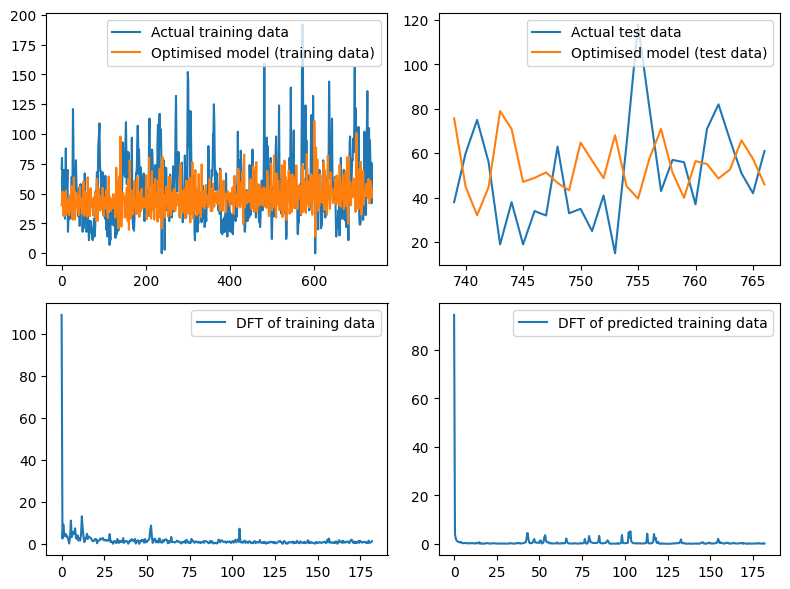

In [105]:
from scipy.optimize import minimize
from tqdm import tqdm

def sinusoid_model(w, t, num_params, log_flag, remove_log = False): # w = 2 * num_params + 2
    
    w_i = w[:num_params].reshape(-1, 1)
    w_j = w[num_params:2 * num_params].reshape(-1, 1)
    seasonality = w[-2]
    bias = w[-1]

    # a_i * np.sin(b_i * t) + c_i * t + d_i 
    # a_i = w_i
    # b_i = w_j
    # c_i = seasonality
    # bias = d_i (Normalised by number of days in a year for stability)

    # print(w_i.shape, w_j.shape, t.shape, seasonality, bias)
    
    y_pred = np.sum(w_i * np.sin(w_j * t.reshape(1, -1)), axis = 0) + bias + seasonality * t / 365
        
    if log_flag and remove_log:
        return np.exp(y_pred)

    else:
        return y_pred

def sinisoidal_loss(w, t, y_act, num_params, log_flag):

    y_pred = sinusoid_model(w, t, num_params, log_flag)
    
    return np.mean((y_pred - y_act)**2)

##############################################################
# Testing the model on a simple set of parameters
##############################################################

# Hyperparameters
product_index = 10
num_params = 20
log_flag = True

# Data
sliced_train_df = train_df[train_df['product_code']==product_index]
y_train = sliced_train_df['volume'].to_numpy()
t_train = sliced_train_df['date_diff'].to_numpy()

sliced_test_df = test_df[test_df['product_code']==product_index]
y_test = sliced_test_df['volume'].to_numpy()[-prediction_length:]
t_test = sliced_test_df['date_diff'].to_numpy()[-prediction_length:]

w0 = np.concatenate([np.abs(np.random.randn(num_params) * 5), 
                     np.random.randint(low=0.1, high = 100, size = (num_params,)), 
                     np.random.rand(1) * 2, 
                     np.mean(y_train, keepdims=True)])

res = minimize(sinisoidal_loss, w0, args=(t_train, np.log(y_train + 1e-6) if log_flag else y_train, num_params, log_flag))

w_opt = res['x']

print(w_opt)

if log_flag:
    print(sinisoidal_loss(w0, t_test, np.log(y_test + 1e-6), num_params, log_flag))
    print(sinisoidal_loss(w_opt, t_test, np.log(y_test + 1e-6), num_params, log_flag))

else:
    print(sinisoidal_loss(w0, t_test, y_test, num_params, log_flag))
    print(sinisoidal_loss(w_opt, t_test, y_test, num_params, log_flag))

y_train_pred = sinusoid_model(w_opt, t_train, num_params, log_flag, remove_log = True)
y_test_pred = sinusoid_model(w_opt, t_test, num_params, log_flag, remove_log = True)

fig, ax = plt.subplots(2, 2, figsize = (8, 6))
ax = ax.flatten()
ax[0].plot(t_train, y_train, label = "Actual training data")
ax[0].plot(t_train, y_train_pred, label = "Optimised model (training data)")
ax[0].legend()

ax[1].plot(t_test, y_test, label = "Actual test data")
ax[1].plot(t_test, y_test_pred, label = "Optimised model (test data)")
ax[1].legend()

n = len(y_train)
ax[2].plot(np.fft.fftfreq(n, 1/365)[:n//2], 2/n * np.abs(np.fft.fft(y_train))[:n//2], label = "DFT of training data")
ax[3].plot(np.fft.fftfreq(n, 1/365)[:n//2], 2/n * np.abs(np.fft.fft(y_train_pred))[:n//2], label = "DFT of predicted training data")

for axs in ax:
    axs.legend()
    
fig.tight_layout()
plt.show()

In [170]:
def create_regression_models(df, num_params, log_flag = False):
    eps = 1e-6
    
    # Compute means for each group
    mean_df = df.groupby('product_code').agg(volume_mean_per_code=('volume', 'mean'))

    # Get the number of product codes
    num_product_codes = len(mean_df) # possible because group by product code
    product_codes = mean_df.index.to_numpy()
    
    # Get the initial parameter matrix
    W_orig = np.hstack([
        np.abs(np.random.randn(num_product_codes, num_params) * 5), 
        np.random.randint(low=0.1, high = 100, size = (num_product_codes, num_params)), 
        np.random.rand(num_product_codes, 1) * 2, 
        mean_df['volume_mean_per_code'].to_numpy().reshape(-1, 1)
    ])

    print(W_orig.shape)

    # Initialise the optimal parameters
    W_opt = np.zeros_like(W_orig)

    # Iterate and optimise
    for i in tqdm(range(num_product_codes)):
        product_index = product_codes[i]
        # Process the training data
        sliced_df = df[train_df['product_code']==product_index]
        y_train = sliced_df['volume'].to_numpy()
        t_train = sliced_df['date_diff'].to_numpy()
        
        # Get the initial parameters
        w0_iter = W_orig[i, :]

        # Optimise
        res = minimize(sinisoidal_loss, w0_iter, args=(t_train, np.log(y_train + eps) if log_flag else y_train, num_params, log_flag))

        # Store
        W_opt[i, :] = res['x']

        # Evaluate

    return W_opt

def make_predictions(W_opt, df, num_params, log_flag, prediction_length):
    
    num_product_codes = W_opt.shape[0] # possible because group by product code
    
    predicted_volume = []

    # Get the sorted data by date and then by product code (so that we can extract the period to extract over
    sliced_df = df.sort_values(by=['sales_date', 'product_code'], ascending=[True, True]).iloc[-num_product_codes*prediction_length:]

    # Re-arrange so that its all of the sales for a given product code
    eval_df = sliced_df.sort_values(by=['product_code', 'sales_date'], ascending=[True, True])
    
    # Super slow, but I am tired
    for i in tqdm(range(len(eval_df))):

        row_data = eval_df.iloc[i]

        t = row_data['date_diff']
        product_code = row_data['product_code']
        w_opt_iter = W_opt[product_code - 1, :]
        
        prediction = sinusoid_model(w_opt_iter, np.array(t), num_params, log_flag, remove_log=True if log_flag else False) # Undo log on prediction
        
        predicted_volume.append(prediction[0])

    # Create the prediction dict
    pred_dict = {
        'sales_date': eval_df['sales_date'].values,
        'product_code': eval_df['product_code'].values,
        'volume': predicted_volume
    }

    # Create the prediction dataframe
    pred_df = pd.DataFrame(pred_dict)

    # Sort by product code and then by sales_date
    pred_df.sort_values(by=['product_code', 'sales_date'], ascending=[True, True], inplace = True)

    return pred_df

In [168]:
# Model parameters
num_params = 20
log_flag = False

W_opt = create_regression_models(train_df, num_params, log_flag)

(411, 42)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [11:15<00:00,  1.64s/it]


In [171]:
# Make predictions
output_preds_path = "submission_results/model_3_predictions.csv"
preds_df = make_predictions(W_opt, test_df, num_params, log_flag, prediction_length)
preds_df.to_csv(output_preds_path, index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11508/11508 [00:01<00:00, 10839.52it/s]


In [172]:
# Evaluate
report = compute_error(data_path, output_preds_path)
print("Sinusoid model error report:")
print(report)

forecast_acc = (1 - (report.rE)) * 100
forecast_bias = report.rB * 100
acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
print(f"Forecast Bias is: {forecast_bias:.2f}%")
print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

Sinusoid model error report:
A     1.199319e+06
P     1.503580e+06
E     7.352396e+05
rE    6.130475e-01
rB    2.536949e-01
dtype: float64
Forecast Accuracy is: 38.70%
Forecast Bias is: 25.37%
Bias-weighted Accuracy: 26.01%


## 9. Submission
********************************
Ensure your notebook runs end-to-end without errors. Save your notebook and required dependencies in a requirements.txt file. Submit your notebook to Zindi for automated evaluation.


In [162]:
# Save the model (if required)

print("Notebook is ready for submission!")


Notebook is ready for submission!
